# Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np

## Lendo o dataset

In [2]:
merged = pd.read_csv('../data/processed/dataset_merged.csv')

# Insights com Machine Learning

## Prever atraso na entrega

### Conferirindo e convertertendo as datas

In [3]:
merged["order_purchase_timestamp"] = pd.to_datetime(
   merged["order_purchase_timestamp"], errors="coerce"
)

merged["order_delivered_customer_date"] = pd.to_datetime(
   merged["order_delivered_customer_date"], errors="coerce"
)

merged["order_estimated_delivery_date"] = pd.to_datetime(
   merged["order_estimated_delivery_date"], errors="coerce"
)


### Calcular quantos dias cada pedido levou para chegar

In [4]:
merged["delivery_days"] = (
   merged["order_delivered_customer_date"] -
   merged["order_purchase_timestamp"]
).dt.days



In [5]:
merged["delivery_days"].head()


0     8.0
1     8.0
2     8.0
3    13.0
4     9.0
Name: delivery_days, dtype: float64

In [6]:
merged_delay = merged[
   (merged["order_status"] == "delivered") &
   (merged["delivery_days"].notna())
].copy()

### Filtrando só pedidos realmente entregues

In [7]:
df_delay = merged[
   (merged["order_status"] == "delivered") &
   (merged["delivery_days"].notna())
].copy()


In [8]:
len(df_delay)


114851

### Calculando o tempo esperado de entrega por estado

In [9]:
median_time = (
   df_delay
   .groupby("customer_state")["delivery_days"]
   .median()
   .reset_index()
   .rename(columns={"delivery_days": "expected_days"})
)


In [10]:
median_time.head()


,customer_state,expected_days
0,AC,18.0
1,AL,21.0
2,AM,26.0
3,AP,24.0
4,BA,16.0


### Juntando com o df_delay

In [11]:
df_delay = df_delay.merge(
   median_time,
   on="customer_state",
   how="left"
)

### Calculando o quanto o pedido passou da média

In [12]:
df_delay["delay_gap"] = df_delay["delivery_days"] - df_delay["expected_days"]

In [13]:
df_delay[[
   "order_id",
   "customer_state",
   "delivery_days",
   "expected_days",
   "delay_gap"
]].head()

,order_id,customer_state,delivery_days,expected_days,delay_gap
0,e481f51cbdc54678b7cc49136f2d6af7,SP,8.0,7.0,1.0
1,e481f51cbdc54678b7cc49136f2d6af7,SP,8.0,7.0,1.0
2,e481f51cbdc54678b7cc49136f2d6af7,SP,8.0,7.0,1.0
3,53cdb2fc8bc7dce0b6741e2150273451,BA,13.0,16.0,-3.0
4,47770eb9100c2d0c44946d9cf07ec65d,GO,9.0,13.0,-4.0


### Criar a variável alvo is_delayed

In [14]:
df_delay["is_delayed"] = (df_delay["delay_gap"] > 3).astype(int)
df_delay["is_delayed"].value_counts(normalize=True)

is_delayed
0    0.715423
1    0.284577
Name: proportion, dtype: float64

### Escolhendo features e montando o dataframe

In [15]:
cols_features = [
   "price",
   "freight_value",
   "payment_value",
   "payment_installments",
   "payment_type",
   "customer_state",
   "year",
   "expected_days"
]

target_col = "is_delayed"

df_model = df_delay[cols_features + [target_col]].copy()
df_model = df_model.dropna(subset=cols_features + [target_col])


In [16]:
df_model.head()


,price,freight_value,payment_value,payment_installments,payment_type,customer_state,year,expected_days,is_delayed
0,29.99,8.72,18.12,1,credit_card,SP,2017,7.0,0
1,29.99,8.72,2.00,1,voucher,SP,2017,7.0,0
2,29.99,8.72,18.59,1,voucher,SP,2017,7.0,0
3,118.70,22.76,141.46,1,boleto,BA,2018,16.0,0
4,159.90,19.22,179.12,3,credit_card,GO,2018,13.0,0


### Transformando variáveis categóricas

In [17]:
X = df_model[cols_features]
y = df_model[target_col]

X_encoded = pd.get_dummies(
   X,
   columns=["payment_type", "customer_state"],
   drop_first=True
)

In [18]:
X_encoded.head()

,price,freight_value,payment_value,payment_installments,year,expected_days,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,customer_state_AL,...,customer_state_PR,customer_state_RJ,customer_state_RN,customer_state_RO,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO
0,29.99,8.72,18.12,1,2017,7.0,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,29.99,8.72,2.00,1,2017,7.0,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2,29.99,8.72,18.59,1,2017,7.0,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
3,118.70,22.76,141.46,1,2018,16.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,159.90,19.22,179.12,3,2018,13.0,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Separando treino e teste

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
   X_encoded,
   y,
   test_size=0.2,
   random_state=42,
   stratify=y
)

### Randon Forest

#### Treinando o modelo

In [20]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(
   n_estimators=300,
   max_depth=None,
   random_state=42,
   n_jobs=-1
)

modelo_rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### Análise dos resultados

##### Acurácia de teste

In [21]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = modelo_rf.predict(X_test)

print("Acurácia no teste:", accuracy_score(y_test, y_pred))
print()
print(classification_report(y_test, y_pred))

Acurácia no teste: 0.7366679726611814

              precision    recall  f1-score   support

           0       0.78      0.88      0.83     16434
           1       0.56      0.38      0.45      6537

    accuracy                           0.74     22971
   macro avg       0.67      0.63      0.64     22971
weighted avg       0.72      0.74      0.72     22971



##### Matriz de confusão

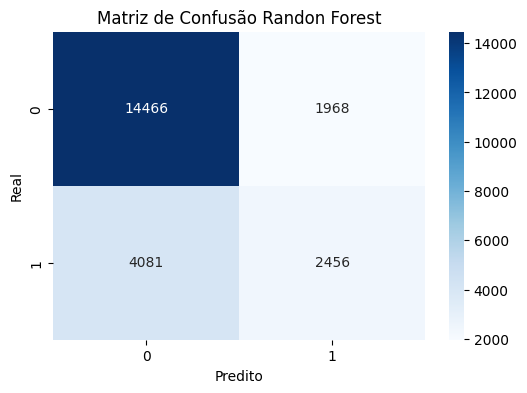

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão Randon Forest")
plt.show()


### XGBoost

#### Importando e montando o modelo

In [24]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

In [25]:
xgb_clf = xgb.XGBClassifier(
   n_estimators=300,
   learning_rate=0.05,
   max_depth=6,
   subsample=0.8,
   colsample_bytree=0.8,
   random_state=42,
   eval_metric="logloss"
)

#### Treinando o modelo

In [26]:
xgb_clf.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


#### Fazendo previsões

In [27]:
y_pred_xgb = xgb_clf.predict(X_test)

#### Avaliando modelo

##### Acurácia de teste

In [28]:
print("Acurácia XGB:", accuracy_score(y_test, y_pred_xgb))
print()
print(classification_report(y_test, y_pred_xgb))

Acurácia XGB: 0.7250010883287623

              precision    recall  f1-score   support

           0       0.73      0.99      0.84     16434
           1       0.71      0.06      0.11      6537

    accuracy                           0.73     22971
   macro avg       0.72      0.52      0.47     22971
weighted avg       0.72      0.73      0.63     22971



#### Matriz de confusão

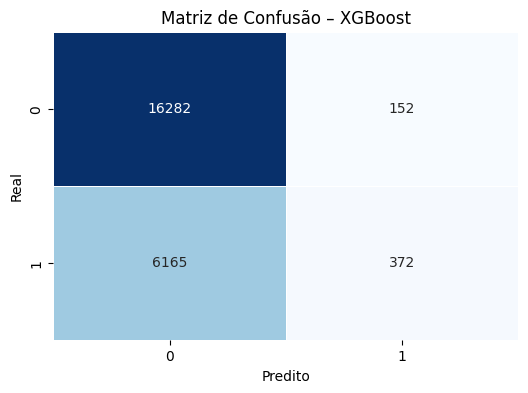

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_xgb)  # pode trocar por y_pred_rf

plt.figure(figsize=(6, 4))
sns.heatmap(
   cm,
   annot=True,
   fmt="d",
   cmap="Blues",
   linewidths=0.5,
   cbar=False
)

plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão – XGBoost")
plt.show()


### Comparando modelos

#### Gerando previsão dos modelos

In [38]:
y_pred_rf = modelo_rf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)


#### Comparando das métricas

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def avaliar(nome, y_test, y_pred):
   print(f"\nModelo: {nome}")
   print("Acurácia:", accuracy_score(y_test, y_pred))
   print("Precisão:", precision_score(y_test, y_pred))
   print("Recall:", recall_score(y_test, y_pred))
   print("F1:", f1_score(y_test, y_pred))

avaliar("Random Forest", y_test, y_pred_rf)
avaliar("XGBoost", y_test, y_pred_xgb)



Modelo: Random Forest
Acurácia: 0.7366679726611814
Precisão: 0.5551537070524413
Recall: 0.3757075110907144
F1: 0.44813429431621205

Modelo: XGBoost
Acurácia: 0.7250010883287623
Precisão: 0.7099236641221374
Recall: 0.056906837999082145
F1: 0.10536751168389746


#### Comparando matrizes de confusão

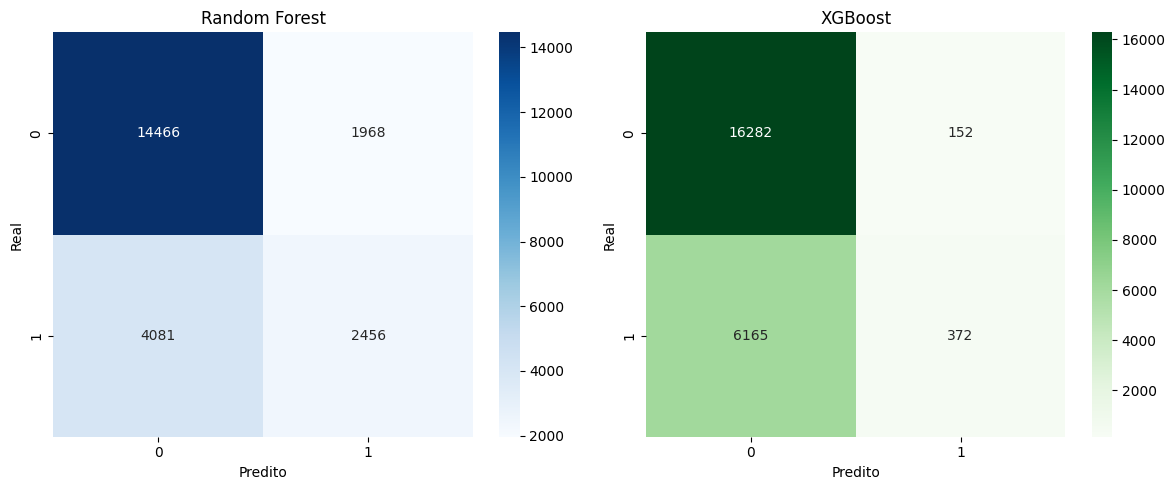

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Random Forest")
axes[0].set_xlabel("Predito")
axes[0].set_ylabel("Real")

sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("XGBoost")
axes[1].set_xlabel("Predito")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.show()


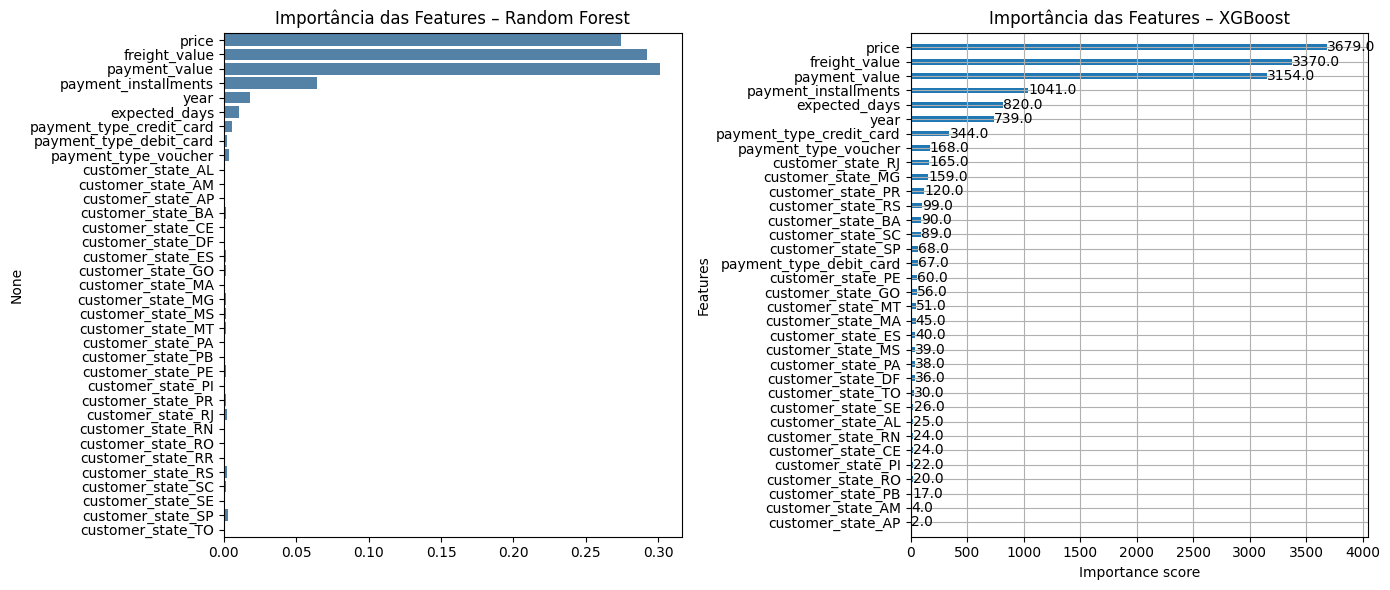

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
importances_rf = modelo_rf.feature_importances_
features_rf = X_train.columns
sns.barplot(
   x=importances_rf,
   y=features_rf,
   ax=axes[0],
   color="steelblue"
)
axes[0].set_title("Importância das Features – Random Forest")

# XGBoost
xgb.plot_importance(xgb_clf, ax=axes[1], height=0.4)
axes[1].set_title("Importância das Features – XGBoost")

plt.tight_layout()
plt.show()


**Conclusão**  
Os primeiros testes mostraram que tanto o Random Forest quanto o XGBoost conseguem acertar bem os pedidos entregues no prazo, mas enfrentam dificuldade em identificar casos de atraso. O Random Forest apresentou desempenho mais equilibrado, conseguindo capturar parte dos atrasos, enquanto o XGBoost praticamente ignorou a classe minoritária e previu quase tudo como entrega dentro do prazo. Esse comportamento fica claro nas matrizes de confusão e nas métricas de recall, que revelam o impacto do forte desbalanceamento do dataset. Em resumo, os modelos até funcionam para reconhecer o padrão geral das entregas, mas ainda não são bons em detectar atrasos, o que indica a necessidade de técnicas adicionais de balanceamento ou ajuste de limiar para melhorar o desempenho na classe positiva.

### Melhorando os modelos

#### Random Forest com class_weight

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

rf_weighted = RandomForestClassifier(
   n_estimators=300,
   random_state=42,
   n_jobs=-1,
   class_weight="balanced"
)

rf_weighted.fit(X_train, y_train)

y_pred_rf_w = rf_weighted.predict(X_test)

print("Random Forest com class_weight")
print("Acurácia:", accuracy_score(y_test, y_pred_rf_w))
print("Precisão:", precision_score(y_test, y_pred_rf_w))
print("Recall:", recall_score(y_test, y_pred_rf_w))
print("F1:", f1_score(y_test, y_pred_rf_w))


Random Forest com class_weight
Acurácia: 0.7340124504810414
Precisão: 0.5458646616541354
Recall: 0.38871041762276276
F1: 0.45407433881343817


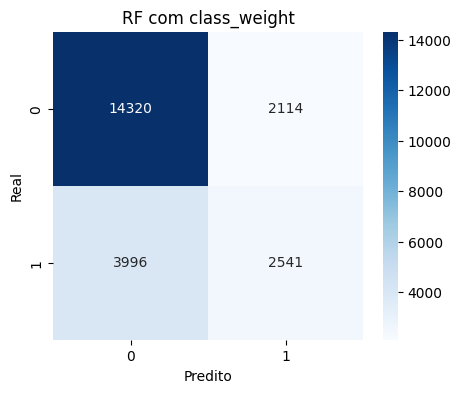

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

cm_rf_w = confusion_matrix(y_test, y_pred_rf_w)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf_w, annot=True, fmt="d", cmap="Blues")
plt.title("RF com class_weight")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


#### Ajuste de threshold no Random Forest

In [ ]:
y_proba_rf = rf_weighted.predict_proba(X_test)[:, 1]

limiar = 0.30  # você pode brincar com 0.25, 0.35 etc
y_pred_rf_thr = (y_proba_rf >= limiar).astype(int)

print(f"\nRF com class_weight e limiar {limiar}")
print("Acurácia:", accuracy_score(y_test, y_pred_rf_thr))
print("Precisão:", precision_score(y_test, y_pred_rf_thr))
print("Recall:", recall_score(y_test, y_pred_rf_thr))
print("F1:", f1_score(y_test, y_pred_rf_thr))


RF com class_weight e limiar 0.3
Acurácia: 0.6696704540507596
Precisão: 0.4425620286370095
Recall: 0.6193972770383969
F1: 0.5162565344893536


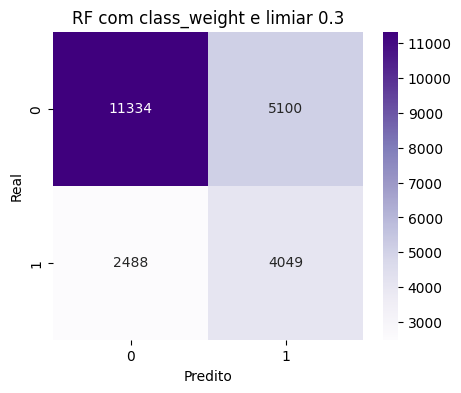

In [46]:
cm_rf_thr = confusion_matrix(y_test, y_pred_rf_thr)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf_thr, annot=True, fmt="d", cmap="Purples")
plt.title(f"RF com class_weight e limiar {limiar}")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()